# Содержание:

    1) Метод doc2vec с классификаторами:
            1) Ridge Classifier
            2) Perceptron
            3) Passive Agressive
            4) BeurnolliNB
            5) MultinomialNB
            6) KNeighbors
            7) RandomForest
            8) NearestCentroid
            9) SGDClassifier
            10) LinearSVC
    2) Визуализация

In [2]:
%matplotlib inline
import os
from lxml import etree
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing

# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause

from __future__ import print_function

import gensim
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
import pymorphy2

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

## Подготовка текстов

In [3]:
class DocIterator(object):
    def __init__(self, doc_list, labels_list):
       self.labels_list = labels_list
       self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
            yield gensim.models.doc2vec.LabeledSentence(words=doc.split(),tags=[self.labels_list[idx]])


In [4]:
f = open('./out.csv', 'r')
cl = {'статья':0,'интервью':1,'комментарий':2}
file_hash = {}
for line in f:
    attrs = line.split(';')
    path = attrs[0]
    class_name = attrs[8]
    if ' ' in class_name:
        class_name = class_name.split()[0]
    if '|' in class_name:
        class_name = class_name.split('|')[0]
    filename = os.path.basename(path)
    if class_name in cl:
        file_hash[filename] = cl[class_name]


In [5]:
def check_len_of_classes():
    f = open('out.csv', 'r')
    dict_len = defaultdict(int)
    for line in f:
        attrs = line.split(';')
        path = attrs[0]
        class_name = attrs[8]
        dict_len[class_name] += 1
    return dict_len

In [52]:
#  check_len_of_classes() 

In [6]:
morph = pymorphy2.MorphAnalyzer()
def normalize_and_add_pos(word):
    p = morph.parse(word)[0]
    return '{}_{}'.format(
        p.normal_form,
        p.tag.POS
    )

2017-04-23 21:44:05,565 INFO Loading dictionaries from /Users/Valeriya/anaconda/lib/python3.5/site-packages/pymorphy2_dicts/data
2017-04-23 21:44:05,667 INFO format: 2.4, revision: 393442, updated: 2015-01-17T16:03:56.586168


In [7]:
def read_txt(path):
    for root, dirs, files in os.walk(path):
        for filename in files:
            open_name = os.path.join(root, filename)
            if filename in file_hash:
                class_text = file_hash[filename]
                tree = etree.parse(open_name)
                yield tree, class_text

In [8]:
sent = []
for tree, class_text in read_txt('/Users/Valeriya/Desktop/CoursePaper/corpus'):
    all_p = tree.xpath('//p')
    joined = '\n'.join([p.text for p in all_p if p.text is not None])
    sent.append((joined, class_text))

In [9]:
len(sent)

1457

In [10]:
only_texts = [text[0] for text in sent]
classes = [text[1] for text in sent]

In [11]:
docLabels = [str(i) for i in range(2506)]

it = DocIterator(only_texts, docLabels)

model = gensim.models.Doc2Vec(window=10, min_count=5, workers=11,alpha=0.025, min_alpha=0.025) # use fixed learning rate
model.build_vocab(it)
for epoch in range(10):
    model.train(it)
    model.alpha -= 0.002 # decrease the learning rate
    model.min_alpha = model.alpha # fix the learning rate, no deca
    model.train(it)

2017-04-23 21:44:25,821 INFO collecting all words and their counts
2017-04-23 21:44:25,822 INFO PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2017-04-23 21:44:26,492 INFO collected 201513 word types and 1457 unique tags from a corpus of 1457 examples and 1222052 words
2017-04-23 21:44:26,493 INFO Loading a fresh vocabulary
2017-04-23 21:44:26,760 INFO min_count=5 retains 28281 unique words (14% of original 201513, drops 173232)
2017-04-23 21:44:26,761 INFO min_count=5 leaves 973617 word corpus (79% of original 1222052, drops 248435)
2017-04-23 21:44:26,873 INFO deleting the raw counts dictionary of 201513 items
2017-04-23 21:44:26,897 INFO sample=0.001 downsamples 30 most-common words
2017-04-23 21:44:26,898 INFO downsampling leaves estimated 839698 word corpus (86.2% of prior 973617)
2017-04-23 21:44:26,899 INFO estimated required memory for 28281 words and 100 dimensions: 37639500 bytes
2017-04-23 21:44:27,032 INFO resetting layer weights
2017-04-23 21:44:27,

In [12]:
X_train, X_test, y_train, y_test = train_test_split(list(model.docvecs), classes, test_size=0.3)

## Классификация

In [13]:
categories = ['статья','интервью','комментарий']

print("Loading dataset for categories:")
print(categories if categories else "all")


print('data loaded')


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

print("Extracting features from the training data using a sparse vectorizer")
t0 = time()


duration = time() - t0


print("Extracting features from the test data using the same vectorizer")
t0 = time()


duration = time() - t0

Loading dataset for categories:
['статья', 'интервью', 'комментарий']
data loaded
Extracting features from the training data using a sparse vectorizer
Extracting features from the test data using the same vectorizer


In [14]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train_norm = min_max_scaler.fit_transform(X_train)
X_test_norm = min_max_scaler.fit_transform(X_test)

In [24]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    if clf == MultinomialNB(alpha=.01):
        clf.fit(X_train, y_train)
    else:
        clf.fit(X_train_norm, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    if clf == MultinomialNB(alpha=.01):
        pred = clf.predict(X_test)
    else:
        pred = clf.predict(X_test_norm)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    print()
    clf_descr = str(clf).split('(')[0]
    if "penalty" in vars(clf):
        return clf_descr+' '+str(clf.penalty), score, train_time, test_time
    else:
        return clf_descr, score, train_time, test_time
        


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                            dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train Logistic Regression
print('=' * 80)
print("Logistic Regression")
results.append(benchmark(LogisticRegression()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC( penalty="l1", dual=False, tol=1e-3))),
  ('classification', LinearSVC())
])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.011s
test time:  0.000s
accuracy:   0.660

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=50, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)
train time: 0.032s
test time:  0.000s
accuracy:   0.420

Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(C=1.0, class_weight=None, fit_intercept=True,
              loss='hinge', n_iter=50, n_jobs=1, random_state=None,
              shuffle=True, verbose=0, warm_start=False)
train time: 0

/Users/Valeriya/anaconda/lib/python3.5/site-packages/sklearn/svm/classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)
/Users/Valeriya/anaconda/lib/python3.5/site-packages/sklearn/svm/classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


train time: 0.559s
test time:  0.001s
accuracy:   0.648

________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 0.077s
test time:  0.000s
accuracy:   0.626

Elastic-Net penalty
________________________________________________________________________________
Training: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
train time: 0.083s
test time:  0.000s
accuracy:   0.619

NearestCentroid (aka Ro

## Визуализация

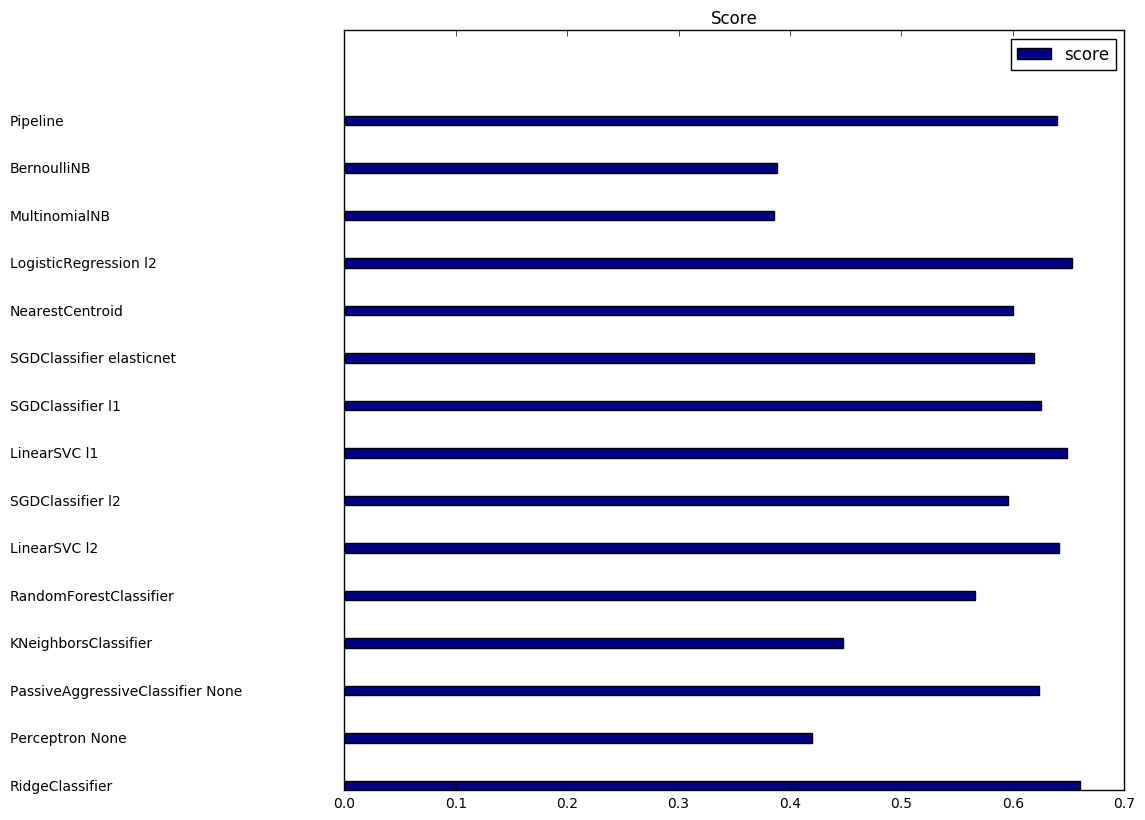

In [25]:
scores = results[1]
cls_names = results[0]

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, scores, .2, label="score", color='navy')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=1)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, results[0]):
    plt.text(-.3, i, c)
plt.show()

In [27]:
file = open('results.txt', 'a')
file.write('Doc2vec Results')
file.write('\n')
file.write('\n')
for name, score in zip(results[0],results[1]):
    file.write(' '.join([name, str(score)]))
    file.write('\n')

file.close()